[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet_ejercicio.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet_ejercicio.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet_ejercicio.ipynb)
[![SageMaker](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet_ejercicio.ipynb)

# Micro ResNet: Recipes2k

<div style="text-align: right"> Bere et Richardt </div>

En este ejemplo realizaremos un repaso rápido de como implementar una red convolucional para clasificación binaria. Emplearemos una versión reducida de Recipes5k, un conjunto de imágenes de comida multietiquetado.

![recipes](https://raw.githubusercontent.com/bereml/riiaa-20-mtl/master/media/recipes5k.jpg)

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

### 1.1. Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

### 1.2. Auxiliares

In [3]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download'
base_dir = '../data/recipes'
filename = 'recipes2k.tar.gz'
data_dir = '../data/recipes/recipes2k'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

## 2 Datos

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/e9fbbe09478011ee08fe45ce2afb63db3fa2c8df/figs/comida_datos.svg" width="1050"/>
&nbsp;
Tuberia de datos para Recipes2k.

### 2.2 Descarga de Recipes2k

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

File ‘../data/recipes/recipes2k.tar.gz’ already there; not retrieving.


### 2.3 Conjunto de datos

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'trn.csv'), index_col='item')
df.head()

,healthy,junk,dessert,appetizer,mains,soups,carbs,protein,fats,meat
item,,,,,,,,,,
apple_pie,0,0,1,0,0,0,1,0,1,0
baby_back_ribs,0,0,0,0,1,0,0,1,1,1
beef_tacos,0,0,0,0,1,0,1,1,1,1
beet_salad,1,0,0,0,1,0,0,1,0,0
bread_pudding,0,0,1,0,0,0,1,0,1,0


In [6]:
! ls {data_dir}/trn/beet_salad | head -5

0_maple_roasted_beet_and_goat_cheese_salad.jpg
10_balsamic_beet_salad_with_arugula_and_goat_cheese.jpg
11_roasted_beet_and_goat_cheese_salad.jpg
12_cathys_bodacious_beet_salad.jpg
13_red_beet_salad.jpg


In [7]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4 Exploración

x shape=torch.Size([32, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


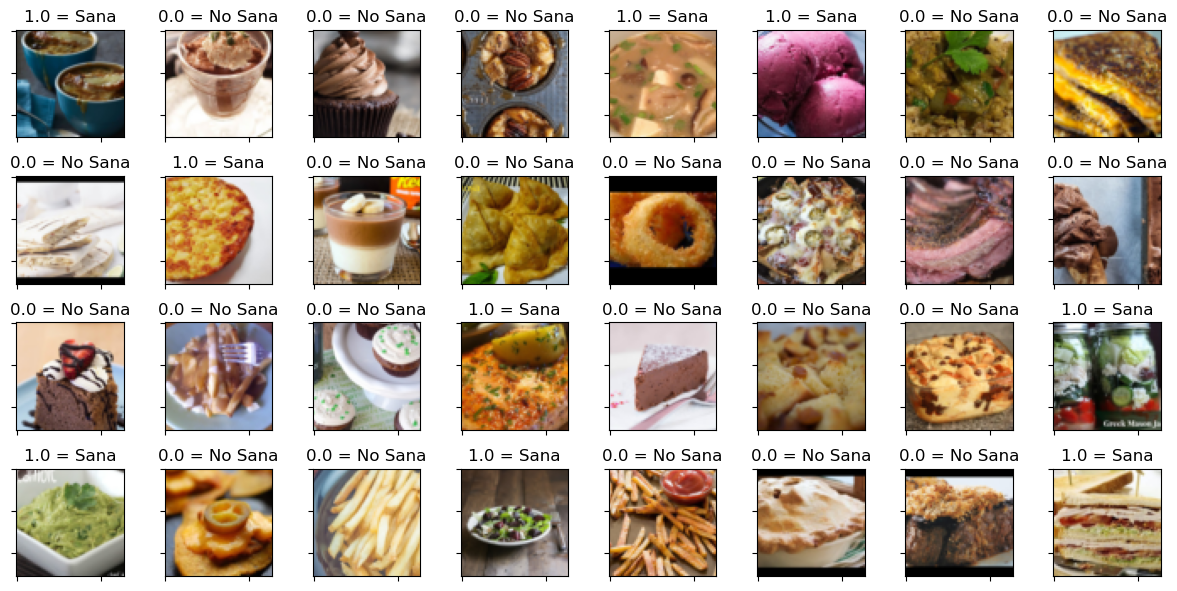

In [8]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = RecipesDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = No Sana' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.3 Cargador de datos

#### Entrenamiento

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


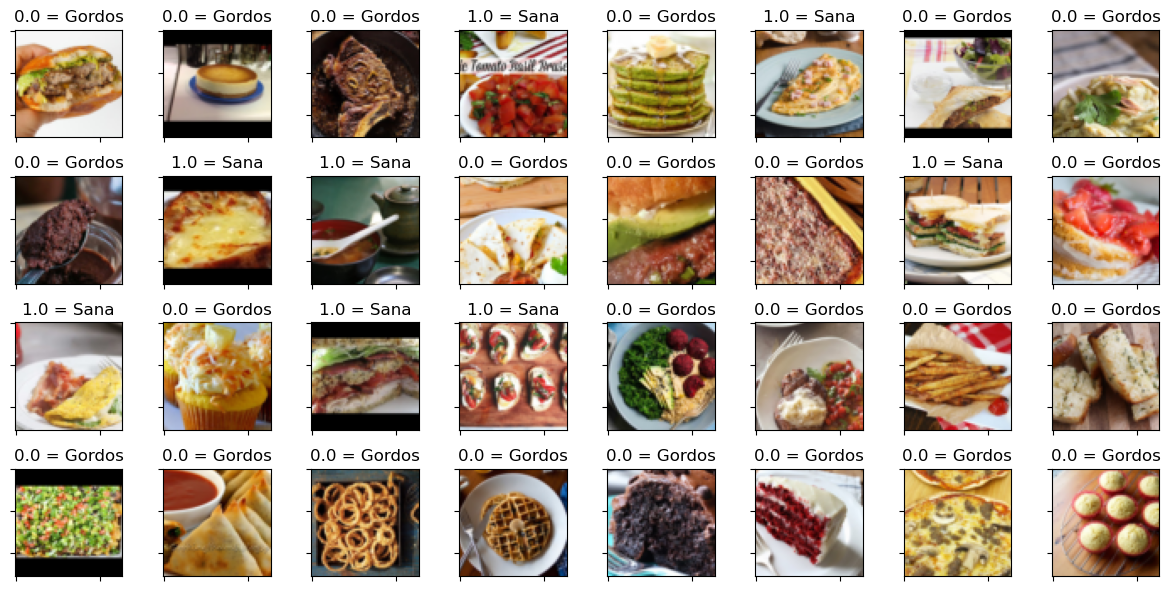

In [9]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

trn_ds = RecipesDS(data_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3 Modelo

<!-- ![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/fc.jpg) -->

### 3.1 Definición de bloque ResNet

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/b0727676e55073692332894e0bec830235888fa6/figs/resnetblock_complete.svg" width="350"/>

In [10]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, padding=1),
            # [N, O1, H, W]
            nn.BatchNorm2d(out_channels1),
            # [N, O1, H, W]
            nn.ReLU(),
            
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
            nn.BatchNorm2d(out_channels2),
            # [N, O2, H, W]
            nn.ReLU(),
        )
        

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x


In [20]:
bd = ResBlock(in_channels=3, out_channels=(4, 8))

bd(torch.rand(1, 3, 10, 10)).shape 

RuntimeError: The size of tensor a (8) must match the size of tensor b (3) at non-singleton dimension 1

### 3.1 Definición de la arquitectura

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/e3341edf80b91d4d7c06e00b96c162f5378484d3/figs/resnet_arq_completa.svg" width="250"/>

In [17]:
torch.rand(1, 3, 10,10).shape

torch.Size([1, 3, 10, 10])

In [12]:
class MicroResNet(nn.Module):

    def __init__(self):
        super(MicroResNet, self).__init__()
        self.num_feats = 16 * 16 * 16
        
        # [N, 3, 64, 64] => [N, 16, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 64, 64] => [N, 8, 64, 64]
            ResBlock(in_channels=3, out_channels=(4, 8)),
            # [N, 8, 64, 64] => [N, 8, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 8, 32, 32] => [N, 16, 32, 32]
            ResBlock(in_channels=8, out_channels=(12, 16)),
            # [N, 16, 32, 32] => [N, 16, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # [N, 16, 16, 16] => [N, 16x16x16]
        self.flatten = nn.Flatten()

        # [N, 16x16x16] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 16, 16, 16]
        x = self.cnn(x)
        # [N, 16, 16, 16] => [N, 16x16x16]
        x = self.flatten(x)
        # [N, 16x16x16] => [N, 1]
        x = self.cls(x)
        return x

    def predict(self, x):
        # [N, 3, 64, 64] => [N, 1]
        y_lgts = self.forward(x)
        # [N, 1]
        y_prob = torch.sigmoid(y_lgts)
        return y_prob

### 3.2 Inspección de la arquitectura

In [13]:
model = MicroResNet()
summary(model, (3, 64, 64), device='cpu', verbose=0)

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: [Sequential: 3-1, Conv2d: 4-1, BatchNorm2d: 4-2, ReLU: 4-3, Conv2d: 4-4, BatchNorm2d: 4-5, ReLU: 4-6]

### 3.3 Prueba de la arquitectura

In [ ]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(y.shape)

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/10c165ec21ef9d52c7b2e7648891f3a2c5d71d95/figs/comida_entrenamiento.svg" width="650"/>

### 4.1 Ciclo de entrenamiento

In [ ]:
def train_epoch(dl, model, opt):
    model.train()
    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):
    model.eval()
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            
            # computamos las clases
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=1e-1, epochs=15,
          trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist

## 5. Probando la vitamina T

In [ ]:
# cargamos imágenes de prueba
imgs = []
tst_dir = os.path.join(data_dir, 'tst')
names = sorted(os.listdir(tst_dir))
for name in names:
    path = os.path.join(tst_dir, name)
    img = io.imread(path)
    size = min(*img.shape[:2])
    img = crop_center(img, size, size)
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    imgs.append(img)

In [ ]:
# desplegamos con probas
titles = []
model.eval()
with torch.no_grad():
    for img in imgs:
        img_torch = numpy_to_torch(img)
        img_torch = img_torch.unsqueeze(0)
        prob = model.predict(img_torch)
        prob = prob.item() * 100
        if prob < 50:
            titles.append(f'Gordos {prob:5.2f}')
        else:
            titles.append(f'Sana {prob:5.2f}')

display_grid(imgs, titles, 3, 4)